In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
#reading the data
file = "C:/Users/USERID/Documents/GitHub/Employment2030/Employment2030/tables/scores_answers.csv"

data = pd.read_csv(file,index_col=['noc','workshop.number'])
data.sort_index(inplace=True)
data.loc[data.share == 'remain constant','share'] = 'constant'
data.dropna(inplace=True)

#splitting up x and y
x = data.drop(['absolute','share','Unnamed: 0','noc_code'],axis=1) #making x data frame
x['work_num'] = x.index.get_level_values(1) #making workshop number a variable as well as an index
x = np.round(x).astype(int)#round x to make discrete

y_abs = data['absolute']
y_share = data['share']
y_share_bin = y_share.where(y_share=='increase','not_increase')

In [3]:
#aggragate y to test against

y_share_agg = pd.DataFrame(data['share']).pivot_table(index = ['noc','workshop.number'], columns = 'share', aggfunc = len).fillna(0)
y_share_agg['sum'] = y_share_agg.sum(axis = 1)
y_share_agg['not_increase'] = y_share_agg['decrease'] + y_share_agg['constant']
y_share_agg.loc[:,y_share_agg.columns!='sum'] = y_share_agg.loc[:,y_share_agg.columns!='sum'].divide(y_share_agg['sum'],axis=0)
y_share_agg['y'] = y_share_agg[['constant','decrease','increase']].idxmax(axis=1)
y_share_agg['binned_y'] = y_share_agg[['increase','not_increase']].idxmax(axis=1)

In [4]:
#not binned
rf = RandomForestClassifier(class_weight="balanced",n_estimators=1000,n_jobs=-1)

predictions = np.zeros((2419,3))

kf = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y_share.iloc[train_index], y_share.iloc[test_index]
    rf.fit(x_train,y_train)
    predictions[test_index] = rf.predict_proba(x_test)

In [5]:
agg_predictions = pd.DataFrame(predictions,index=x.index).mean(level=[0,1])

In [6]:
accuracy = pd.DataFrame({'constant':abs(agg_predictions.iloc[:,0]-y_share_agg['constant']),
              'decrease':abs(agg_predictions.iloc[:,1]-y_share_agg['decrease']),
              'increase':abs(agg_predictions.iloc[:,2]-y_share_agg['increase'])},
            index = y_share_agg.index)

In [7]:
accuracy.mean()

constant    0.118208
decrease    0.179168
increase    0.179239
dtype: float64

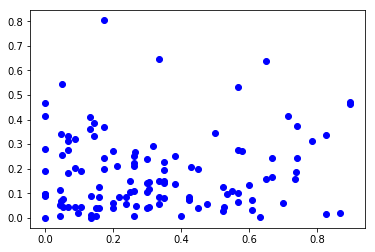

In [8]:
plt.plot(y_share_agg['increase'],accuracy['increase'],'bo')

In [14]:
pd.DataFrame({"truth":y_share_agg['y'], "guess":accuracy.idxmax(axis=1)})

,,truth,guess
noc,workshop.number,,
Accommodation service managers,4,constant,constant
Accounting technicians and bookkeepers,4,decrease,increase
"Air pilots, flight engineers and flying instructors",3,constant,constant
Air transport ramp attendants,3,decrease,decrease
Airline ticket and service agents,3,decrease,decrease
Carpenters,3,increase,increase
"Central control and process operators, petroleum, gas and chemical processing",1,decrease,increase
Chefs,4,increase,increase
Computer network technicians,1,increase,increase


In [6]:
#binned
rf = RandomForestClassifier(class_weight="balanced",n_estimators=1000,n_jobs=-1)

predictions_bin = np.zeros((2419,2))

kf = KFold(n_splits=10,shuffle=False)
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y_share_bin.iloc[train_index], y_share_bin.iloc[test_index]
    rf.fit(x_train,y_train)
    predictions_bin[test_index] = rf.predict_proba(x_test)

In [7]:
agg_predictions_bin = pd.DataFrame(predictions_bin,index=x.index).mean(level=[0,1])

In [11]:
accuracy_bin = pd.DataFrame({'increase':abs(agg_predictions_bin.iloc[:,0]-y_share_agg['increase']),
              'not_increase':abs(agg_predictions_bin.iloc[:,1]-y_share_agg['not_increase'])},
               index = y_share_agg.index)

In [13]:
accuracy_bin.mean()

increase        0.239921
not_increase    0.239921
dtype: float64

In [17]:
pd.DataFrame({"truth":y_share_agg['binned_y'], "guess":accuracy_bin.idxmax(axis=1)})

,,truth,guess
noc,workshop.number,,
Accommodation service managers,4,not_increase,not_increase
Accounting technicians and bookkeepers,4,not_increase,not_increase
"Air pilots, flight engineers and flying instructors",3,not_increase,increase
Air transport ramp attendants,3,not_increase,increase
Airline ticket and service agents,3,not_increase,not_increase
Carpenters,3,not_increase,not_increase
"Central control and process operators, petroleum, gas and chemical processing",1,not_increase,increase
Chefs,4,increase,increase
Computer network technicians,1,increase,increase
